In [1]:
import pandas as pd

In [2]:
triplets = pd.read_csv('data/triplets_file.csv')

In [3]:
me = pd.read_csv('data/me.csv')

In [4]:
song_data = pd.read_csv('data/song_data.csv')

In [5]:
# add me data to the top of the triplets file
triplets = pd.concat([me, triplets], ignore_index=True)

In [6]:
triplets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000012 entries, 0 to 2000011
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [7]:
triplets.listen_count.describe()

count    2.000012e+06
mean     3.045489e+00
std      6.579702e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.213000e+03
Name: listen_count, dtype: float64

In [8]:
# set all listen count higher than 130 to 130
triplets.loc[triplets.listen_count > 130, 'listen_count'] = 130

<AxesSubplot: >

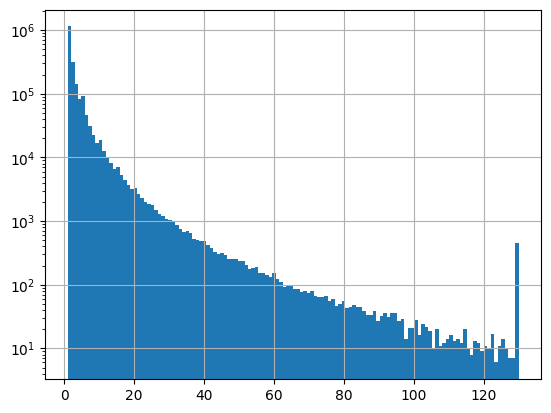

In [9]:
# plot the log distribution of listen count, bins = 130, in log value
triplets.listen_count.hist(bins=130, log=True)

In [10]:
display(triplets.isna().sum().sort_values())

user_id         0
song_id         0
listen_count    0
dtype: int64

In [11]:
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans

In [12]:
# load the first 100000 rows of the triplets file
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 130))


In [13]:
reader = Reader(rating_scale=(1, 130))  
surprise_data = Dataset.load_from_df(triplets[['user_id', 'song_id', 'listen_count']].head(100000), reader)

In [14]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

In [15]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [16]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


In [17]:
class collab_filtering_based_recommender_model():
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        printmd('**Fitting the train data...**')
        self.model.fit(self.trainset)       

        printmd('**Predicting the test data...**')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse) + '**')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['userId', 'productId', 'Rating'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['productId', 'Rating'])
            subdf['userId'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]        
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
        return rmse
        
    def cross_validate(self):
        printmd('**Cross Validating the data...**')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result)  + '**')
        return cv_result

    def recommend(self, user_id, n=5):
        printmd('**Recommending top ' + str(n)+ ' products for userid : ' + user_id + ' ...**')
        
        #df = pd.DataFrame(self.top_n[user_id], columns=['productId', 'Rating'])
        #df['UserId'] = user_id
        #cols = df.columns.tolist()
        #cols = cols[-1:] + cols[:-1]
        #df = df[cols].head(n)
        df = self.recommenddf[self.recommenddf['userId'] == user_id].head(n)
        display(df)
        return df
        

In [18]:
from surprise.model_selection import RandomizedSearchCV

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf


In [19]:
# use the first 10000 rows of the data to find the best model
#surprise_data_10000 = Dataset.load_from_df(triplets[['user_id', 'song_id', 'listen_count']].head(10000), reader)

In [20]:


sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)



Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity 

In [21]:
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender_model(knnwithmeans, trainset, testset, surprise_data)

In [22]:
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict()

**Fitting the train data...**

Computing the msd similarity matrix...
Done computing similarity matrix.


**Predicting the test data...**

RMSE: 5.4825


**RMSE for the predicted result is 5.483**

In [23]:
result_knn_user1 = col_fil_knnwithmeans.recommend(user_id='1234_thisisme', n=10)

**Recommending top 10 products for userid : 1234_thisisme ...**

,userId,productId,Rating
0,1234_thisisme,SOICNON12A8C140437,1.58913
1,1234_thisisme,SOCVTLJ12A6310F0FD,1.58913


In [24]:
song_data = pd.read_csv('data/song_data.csv')

In [25]:
# get song info from song_data by joining
result_knn_user1 = pd.merge(result_knn_user1, song_data, how='left', left_on='productId', right_on='song_id')

In [26]:
result_knn_user1

,userId,productId,Rating,song_id,title,release,artist_name,year
0,1234_thisisme,SOICNON12A8C140437,1.58913,SOICNON12A8C140437,Life In Technicolor ii,Viva La Vida - Prospekt's March Edition,Coldplay,2008
1,1234_thisisme,SOCVTLJ12A6310F0FD,1.58913,SOCVTLJ12A6310F0FD,Clocks,A Rush Of Blood To The Head,Coldplay,2002


In [27]:
from Helper import *

In [28]:
# get random userid
random_user_id = triplets['user_id'].sample(1).values[0]
print(random_user_id)

fc924daf6b7cca932124239ef755f49ac1e6cfda


In [29]:
user_his = show_user_history(random_user_id, triplets).join(song_data.set_index('song_id'), on='song_id')
user_his

,user_id,song_id,listen_count,title,release,artist_name,year
1565856,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOADJQJ12A8C141D38,1,Halo,Halo,Beyoncé,2008
1565857,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOAQMNM12AB0188D7A,1,You And Me (Wedding Version),Old Dogs Original Soundtrack,Lifehouse,2005
1565858,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOAZRJG12A6D4F8A30,1,On Green Dolphin Street (Medley) (1999 Digital...,30 By Ella,Ella Fitzgerald,1968
1565859,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOBNJIY12A8C141E74,1,Kiss Me Thru The Phone,Kiss Me Thru The Phone,Soulja Boy Tell'em / Sammie,2009
1565860,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOBONKR12A58A7A7E0,2,You're The One,If There Was A Way,Dwight Yoakam,1990
1565861,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOCLMAD12AB017FC09,2,Tim McGraw,Taylor Swift,Taylor Swift,2006
1565862,fc924daf6b7cca932124239ef755f49ac1e6cfda,SODCADR12AF72A1A99,1,Whataya Want From Me,Whataya Want From Me,Adam Lambert,2009
1565863,fc924daf6b7cca932124239ef755f49ac1e6cfda,SODLLYS12A8C13A96B,3,Breakeven,Now That's What I Call Music! 72,The Script,2008
1565864,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOFKFXC12AC90732A5,1,Down To Earth,My World,Justin Bieber,2009
1565865,fc924daf6b7cca932124239ef755f49ac1e6cfda,SOFOFLZ12A58A793C7,2,By Your Side,WOW Hits 2010,Tenth Avenue North,2008


In [30]:
show_most_listend_artist(user_his)

Most listened artists by user:
Taylor Swift                                     6
Justin Bieber                                    5
OneRepublic                                      3
Eminem                                           2
B.o.B                                            2
Brandon Heath                                    2
Tenth Avenue North                               2
Jimmy Eat World                                  1
Kid Cudi / MGMT / Ratatat                        1
Travie McCoy                                     1
Katy Perry                                       1
Valerio Scanu                                    1
Misfits                                          1
Drake / Kanye West / Lil Wayne / Eminem          1
Metallica                                        1
Tab Benoit                                       1
Justin Bieber / Jessica Jarrell                  1
Sanctus Real                                     1
NEEDTOBREATHE                                    1
